In [3]:
# Initial imports
import panel as pn
pn.extension('plotly')

import datetime as dt
import hvplot.pandas
import json
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import seaborn as sns
import time

from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline

## Part 1: Trading Volume by Fiat Currency

Coinbase provides trading volume data for 3 fiat currencies: the US Dollar (USD), the Euro (EUR), and the British Pound (GBP). The following visualizations compare the trading volumes between those fiat currencies from 2012 to 2021.

In [10]:
fiat_currencies = ["USD", "EUR", "GBP"]

# Load Coinbase historical data from CSV file
coinbase_historical_data_filepath = Path("../data/coinbase_historical_data.csv")
trading_volume_data_df = pd.read_csv(coinbase_historical_data_filepath)
trading_volume_data_df["date"] = pd.to_datetime(trading_volume_data_df["date"])
trading_volume_data_df.head()

,low,high,open,close,volume,base_currency,quote_currency,date
0,0.4563,0.4783,0.4572,0.4699,212031.0,ALGO,EUR,2021-01-24
1,0.4128,0.4705,0.4191,0.4575,2312202.0,ALGO,EUR,2021-01-23
2,0.3528,0.4438,0.3804,0.4188,2636644.0,ALGO,EUR,2021-01-22
3,0.3691,0.4533,0.4526,0.3793,1693635.0,ALGO,EUR,2021-01-21
4,0.4010,0.4530,0.4317,0.4525,3203612.0,ALGO,EUR,2021-01-20


In [11]:
def trading_volume():
    """
    Visualize trading volume for each fiat currency.
    """
    fiat_volume_df = trading_volume_data_df[["date", "quote_currency", "volume"]].groupby(["date", "quote_currency"]).sum()
    return fiat_volume_df.hvplot.line(x="date", y="volume", by="quote_currency", title="Trading Volume by Fiat Currency", height=500, width=1000)

In [12]:
def unique_cryptocurrency_count():
    """
    Visualize the number of unique traded cryptocurrencies for each fiat currency.
    """
    crypto_count_df = trading_volume_data_df.groupby(["date", "quote_currency"])["base_currency"].nunique()
    return crypto_count_df.hvplot.line(x="date", y="base_currency", by="quote_currency", title="Count of Unique Cryptocurrencies", height=300, width=1000)

In [13]:
def trading_volume_std():
    """
    Visualize trading volume standard deviation for each fiat currency.
    """
    # Get daily change in trading volume
    fiat_volume_data_df = pd.concat([trading_volume_data_df[trading_volume_data_df["quote_currency"] == fiat].groupby(["date"])["volume"].sum() for fiat in fiat_currencies], axis=1)
    fiat_volume_data_df.columns = fiat_currencies
    fiat_volume_pct_df = fiat_volume_data_df.pct_change()

    # calculate standard deviation
    volume_std = fiat_volume_pct_df.std()

    # Calculate rolling standard deviation
    rolling_volume_std = fiat_volume_pct_df.rolling(window=21).std()

    # Plot rolling standard deviation
    return px.line(data_frame=rolling_volume_std, width=1000, height=400, title="Standard Deviation of Trading Volume By Fiat Currency (21-day rolling window)")

In [14]:
# Get the top 3 cryptocurrency by trading volume for each fiat currency
for fiat in fiat_currencies:
    top3 = list(trading_volume_data_df[trading_volume_data_df["quote_currency"] == fiat].groupby(["base_currency"])["volume"].sum().sort_values(ascending=False).head(3).index)
    print(f"{fiat} Top 3 by Trading Volume: {top3}")

USD Top 3 by Trading Volume: ['XLM', 'GRT', 'OXT']
EUR Top 3 by Trading Volume: ['XLM', 'GRT', 'ZRX']
GBP Top 3 by Trading Volume: ['GRT', 'NU', 'ALGO']


# Part 2: Compare Between Cryptos

Analyze the closing prices (Jan 2011 - Jan 2021) for the top 10 trading cryptos per CoinMarketCap

In [8]:
all_crypto = pd.ExcelFile('/Users/aalfiler/Sites/project1_git_repo/Project_1/data/CoinMarketCap_18JAN2020-close.xlsx')
all_close = pd.read_excel(all_crypto, 'All')
all_close.head()

,Date,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
0,2021-01-01,32127.27,774.53,163.09,136.94,143.12,86.97,69.50,56.79,341.99,88.27
1,2020-12-31,29374.15,730.37,163.12,126.23,136.05,88.24,71.96,63.99,343.05,89.10
2,2020-12-30,29001.72,737.80,163.63,124.69,156.57,99.61,62.04,64.20,358.81,87.88
3,2020-12-29,28840.95,751.62,166.90,129.47,159.37,101.68,61.26,66.54,353.09,87.67
4,2020-12-28,27362.44,731.52,164.40,129.04,161.39,104.04,58.24,69.02,362.09,87.39


In [9]:
all_close.shape

(2806, 11)

In [10]:
all_close.dtypes

Date                datetime64[ns]
Bitcoin-BTC                float64
Ethereum-ETH               float64
Bitcoin-BSV                float64
Litecoin-LTC               float64
Monero-XMR                 float64
Dash-DASH                  float64
Kusama-KSM                 float64
Zcash-ZEC                  float64
Bitcoin Cash-BCH           float64
Counos-CCXX                float64
dtype: object

In [11]:
all_close.isnull().sum()

Date                   0
Bitcoin-BTC            0
Ethereum-ETH         831
Bitcoin-BSV         2021
Litecoin-LTC           0
Monero-XMR           389
Dash-DASH            292
Kusama-KSM          2420
Zcash-ZEC           1281
Bitcoin Cash-BCH    1548
Counos-CCXX         2550
dtype: int64

In [26]:
all_close["Bitcoin-BTC"] = all_close["Bitcoin-BTC"].fillna(0)
all_close["Ethereum-ETH"] = all_close["Ethereum-ETH"].fillna(0)
all_close["Bitcoin-BSV"] = all_close["Bitcoin-BSV"].fillna(0)
all_close["Litecoin-LTC"] = all_close["Litecoin-LTC"].fillna(0)
all_close["Monero-XMR"] = all_close["Monero-XMR"].fillna(0)
all_close["Dash-DASH"] = all_close["Dash-DASH"].fillna(0)
all_close["Kusama-KSM"] = all_close["Kusama-KSM"].fillna(0)
all_close["Zcash-ZEC"] = all_close["Zcash-ZEC"].fillna(0)
all_close["Bitcoin Cash-BCH"] = all_close["Bitcoin Cash-BCH"].fillna(0)
all_close["Counos-CCXX"] = all_close["Counos-CCXX"].fillna(0)

In [7]:
all_close.isnull().sum()

Date                0
Bitcoin-BTC         0
Ethereum-ETH        0
Bitcoin-BSV         0
Litecoin-LTC        0
Monero-XMR          0
Dash-DASH           0
Kusama-KSM          0
Zcash-ZEC           0
Bitcoin Cash-BCH    0
Counos-CCXX         0
dtype: int64

In [27]:
all_date_index = all_close.set_index("Date")
all_date_index.head()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
Date,,,,,,,,,,
2021-01-01,32127.27,774.53,163.09,136.94,143.12,86.97,69.50,56.79,341.99,88.27
2020-12-31,29374.15,730.37,163.12,126.23,136.05,88.24,71.96,63.99,343.05,89.10
2020-12-30,29001.72,737.80,163.63,124.69,156.57,99.61,62.04,64.20,358.81,87.88
2020-12-29,28840.95,751.62,166.90,129.47,159.37,101.68,61.26,66.54,353.09,87.67
2020-12-28,27362.44,731.52,164.40,129.04,161.39,104.04,58.24,69.02,362.09,87.39


In [13]:
all_date_index.shape

(2806, 10)

In [28]:
# Group by year
all_date_index_grp = all_date_index.groupby([all_date_index.index.year]).mean()
all_date_index_grp

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
Date,,,,,,,,,,
2013,260.043710,0.000000,0.000000,6.748347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014,525.984082,0.000000,0.000000,9.784986,0.951736,3.241430,0.000000,0.000000,0.000000,0.000000
2015,272.782384,0.374712,0.000000,2.696932,0.490705,2.762110,0.000000,0.000000,0.000000,0.000000
2016,570.033197,9.797840,0.000000,3.791475,3.725023,8.065628,0.000000,30.250519,0.000000,0.000000
2017,4040.715452,226.009726,0.000000,50.646986,76.847452,251.139918,0.000000,193.241973,394.454630,0.000000
2018,7545.412082,481.776767,13.727890,105.236411,167.192466,335.003370,0.000000,228.870932,865.525014,0.000000
2019,7404.442932,181.742795,109.121589,69.694438,66.484110,96.388740,0.074712,56.539425,261.375123,0.000000
2020,11176.962514,309.181066,193.752432,56.473689,85.190191,82.024754,17.360656,57.109590,270.211120,25.014863
2021,32127.270000,774.530000,163.090000,136.940000,143.120000,86.970000,69.500000,56.790000,341.990000,88.270000


In [44]:
# Plot closing prices
all_date_index_grp.hvplot(title="CoinMarketCap: Crypto Closing Prices", ylabel="Closing Price", xlabel="Year", kind='line', width=1000, height=500, x="Date")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [45]:
# Bar plot showing the total closing cost per day
all_date_index_grp.hvplot.bar(x='Date', y=["Bitcoin-BTC", "Ethereum-ETH", "Bitcoin-BSV", "Litecoin-LTC", "Monero-XMR", "Dash-DASH", "Kusama-KSM", "Zcash-ZEC", "Bitcoin Cash-BCH", "Counos-CCXX"],
                 stacked=True, rot=90, width=1000, height=450, ylabel="Closing Price", xlabel="Year", title="CoinMarketCap: Combined Closing Prices")

:Bars   [Date,Variable]   (value)

In [19]:
all_date_index_grp.describe()

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
count,9.000000,7.000000,4.000000,9.000000,8.000000,8.000000,3.000000,6.000000,5.000000,2.000000
mean,7102.627372,283.424086,140.126288,49.112585,68.075096,108.255032,29.431973,128.048838,526.672351,62.086843
std,10197.365827,273.709616,46.340742,48.597191,64.323361,122.599347,35.601821,79.891911,324.116000,37.028576
min,260.043710,0.930406,94.541132,2.696932,0.490705,2.762110,1.435263,56.539425,261.375123,35.903686
25%,525.984082,95.770317,105.476475,6.748347,3.181472,6.970656,9.397959,56.869898,270.211120,48.995265
50%,4040.715452,226.009726,136.105795,50.646986,71.665781,84.497377,17.360656,116.425351,341.990000,62.086843
75%,7545.412082,395.478916,170.755608,69.694438,99.672643,135.076534,43.430328,188.866757,865.525014,75.178422
max,32127.270000,774.530000,193.752432,136.940000,167.192466,335.003370,69.500000,228.870932,894.260497,88.270000


In [20]:
# Calculate the correlation between cryptos
correlation = all_date_index.corr() 
correlation

,Bitcoin-BTC,Ethereum-ETH,Bitcoin-BSV,Litecoin-LTC,Monero-XMR,Dash-DASH,Kusama-KSM,Zcash-ZEC,Bitcoin Cash-BCH,Counos-CCXX
Bitcoin-BTC,1.000000,0.742581,0.458364,0.774062,0.748664,0.531780,0.846605,0.108542,0.267284,0.921958
Ethereum-ETH,0.742581,1.000000,0.401797,0.887323,0.940365,0.819600,0.917055,0.664010,0.801114,0.860397
Bitcoin-BSV,0.458364,0.401797,1.000000,0.249866,0.391009,0.229952,-0.255501,0.241162,0.564865,-0.383879
Litecoin-LTC,0.774062,0.887323,0.249866,1.000000,0.951075,0.878492,0.613489,0.616342,0.847208,0.849895
Monero-XMR,0.748664,0.940365,0.391009,0.951075,1.000000,0.917546,0.873370,0.687765,0.910529,0.862860
Dash-DASH,0.531780,0.819600,0.229952,0.878492,0.917546,1.000000,0.182363,0.800289,0.951691,0.600996
Kusama-KSM,0.846605,0.917055,-0.255501,0.613489,0.873370,0.182363,1.000000,0.536389,0.030293,0.786707
Zcash-ZEC,0.108542,0.664010,0.241162,0.616342,0.687765,0.800289,0.536389,1.000000,0.925310,0.270331
Bitcoin Cash-BCH,0.267284,0.801114,0.564865,0.847208,0.910529,0.951691,0.030293,0.925310,1.000000,0.575663
Counos-CCXX,0.921958,0.860397,-0.383879,0.849895,0.862860,0.600996,0.786707,0.270331,0.575663,1.000000


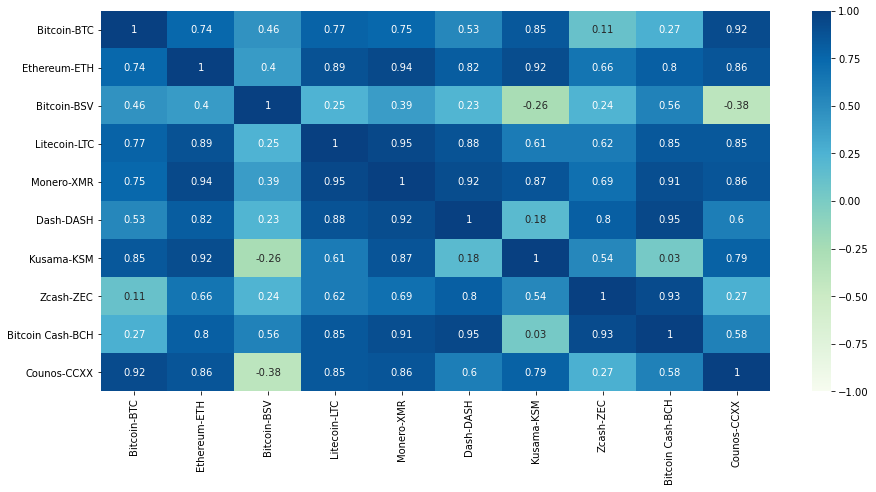

In [60]:
# Plot correlation via Seaborn
plt.figure(figsize = (15,7))
intra_corr_plot = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap="GnBu")
intra_corr_plot.figure.savefig("intra_corr_plot.png", bbox_inches="tight")

In [24]:
# Calculate rolling stats: asses the risk over time
all_roll_std = all_date_index.rolling(window=30).std()

<AxesSubplot:title={'center':'Crypto 30 Day Rolling Standard Deviation'}, xlabel='Date'>

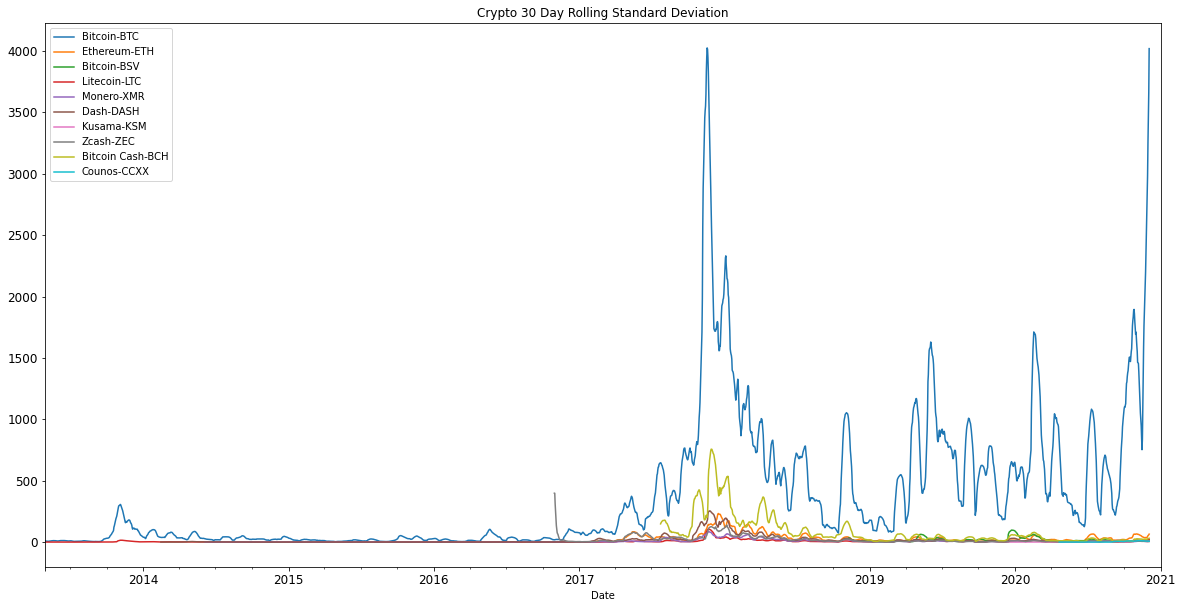

In [25]:
# Plot the rolling standard deviation
all_roll_std.plot(figsize=(20, 10), title="Crypto 30 Day Rolling Standard Deviation", fontsize=12)

## Panel Dashboard

In [15]:
# Generate the plots for each tab
trading_volume_plots = pn.Column("### Trading Volume by Fiat Currency", trading_volume, unique_cryptocurrency_count, trading_volume_std)

# Generate the dashboard with tabs
dashboard = pn.Tabs(
    ('Trading Volume', trading_volume_plots)
)

In [16]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Column()
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive01463')
        [2] Column
            [0] Column()
            [1] Row
                [0] HoloViews(NdOverlay, name='interactive01598')
        [3] Column
            [0] Column()
            [1] Row
                [0] Plotly(Figure, name='interactive01733')